In [1]:
# GENERAL PACKAGE IMPORT
# ----------------------
import sys
sys.path.append('/Users/huangwp/Documents/git/HIL-Sim/flexlab/db_layer') 
from db_interface import DB_Interface
import requests
import numpy as np
import json
import pandas as pd
from pandas import DataFrame
from io import StringIO

import datetime as dt
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.dates import date2num
import seaborn
import timeit
import json
import pickle

import matplotlib.pyplot as plt
import datetime
import db_plotting

In [2]:
data22 = pd.read_csv('data22_revised.csv', parse_dates = True, index_col = 0)
data23 = pd.read_csv('data23_revised.csv', parse_dates = True, index_col = 0)

data22['datetime'] = pd.to_datetime(data22['datetime'])
data23['datetime'] = pd.to_datetime(data23['datetime'])



In [3]:
print(type(data22['datetime'].iloc[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [4]:
data22['gta_window'] = 0
data23['gta_window'] = 0

gta_st = datetime.time(14,0,0)
gta_en = datetime.time(18,0,0)

data22['date'] = data22['datetime'].apply(lambda x: datetime.date(x.year, x.month, x.day))
data22['time'] = data22['datetime'].apply(lambda x: datetime.time(x.hour, x.minute, x.second))

data23['date'] = data23['datetime'].apply(lambda x: datetime.date(x.year, x.month, x.day))
data23['time'] = data23['datetime'].apply(lambda x: datetime.time(x.hour, x.minute, x.second))

gta_ts = (data22['time'] > gta_st) & (data22['time'] <= gta_en)

data22['gta_window'][gta_ts] = 1
data23['gta_window'][gta_ts] = 1

#print(data22['gta_window'][gta_ts])

/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1113/4235634339.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data22['gta_window'][gta_ts] = 1
/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1113/4235634339.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data23['gta_window'][gta_ts] = 1


In [5]:
print(data22.columns)

Index(['desk1_plug_power', 'desk2_plug_power', 'desk3_plug_power',
       'desk4_plug_power', 'desk5_plug_power', 'desk6_plug_power',
       'desk3_light_power', 'desk4_light_power', 'desk2_light_power',
       'desk1_6_light_power', 'desk5_light_power', '1A-VAV1-Zn_Temp',
       '1A-VAV2-Zn_Temp', '1A-VAV3-Zn_Temp', '1A-VAV1-OccupiedCoolingSetpt',
       '1A-VAV1-UnoccupiedCoolingSetpt', '1A-VAV1-OccupiedHeatingSetpt',
       '1A-VAV1-UnoccupiedHeatingSetpt', '1A-VAV2-OccupiedCoolingSetpt',
       '1A-VAV2-UnoccupiedHeatingSetpt', '1A-VAV2-UnoccupiedCoolingSetpt',
       '1A-VAV2-OccupiedHeatingSetpt', '1A-VAV3-OccupiedCoolingSetpt',
       '1A-VAV3-UnoccupiedHeatingSetpt', '1A-VAV3-UnoccupiedCoolingSetpt',
       '1A-VAV3-OccupiedHeatingSetpt', '1A-El-AHU', '1A-El-CHWP', '1A-El-HWP',
       '1A-El-Exhaust Fan', '1A-Th-Chilled Water', '1B-OAT-1',
       '1A-MidZone-TCS6-DBT', '1A-NorthZone-DBT', '1A-WindowZone-TCS7-DBT',
       '1A-VAV1-DischargeAirTemp', '1A-VAV2-DischargeAirTemp',
 

### Metrics

In [6]:
data22 = data22.assign(COP='COP') 
#data22['COP'] = data22['oat_C'].apply(lambda x: (0.548 + 0.0951*x + (-7.63E-04)*x**2))
data22['COP'] = 2.9
data23 = data23.assign(COP='COP') 
#data23['COP'] = data23['oat_C'].apply(lambda x: (0.548 + 0.0951*x + (-7.63E-04)*x**2))
data23['COP'] = 2.9

In [7]:
data22 = data22.assign(chiller = 'Chiller_load') 
data22['Chiller_load'] = (data22['1A-Th-Chilled Water']/data22['COP'])*-1
data22['cooling_power [W]'] = data22['1A-El-AHU'] + data22['1A-El-Exhaust Fan'] + data22['1A-El-CHWP'] + data22['Chiller_load']

data23 = data23.assign(chiller = 'Chiller_load') 
data23['Chiller_load'] = (data23['1B-Th-Chilled Water']/data23['COP'])*-1
data23['cooling_power [W]'] = data23['1B-El-AHU'] + data23['1B-El-Exhaust Fan'] + data23['1B-El-CHWP'] + data23['Chiller_load']

In [8]:
day_range=[8,20,21]

en_1a = []
en_1b = []

# define dates for the calculation
for day in range(day_range[1], day_range[2]+1):    
    mask_1 = data23['date'] == datetime.date(2021, day_range[0], day)
    print(day)
    day_en_1a = round((data22['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
      
    day_en_1b = round((data23['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1b.append(day_en_1b)
    
print(en_1a)
print(en_1b)

20
21
[12.84, 13.66]
[4.63, 3.9]


In [9]:
test_day_mask = (data23['date'] >= datetime.date(2021, day_range[0], day_range[1])) & (data23['date'] <= datetime.date(2021, day_range[0], day_range[2])) 

In [10]:
day_range[2]

21

In [11]:
print(test_day_mask)

time
2021-08-19 23:45:00    False
2021-08-20 00:00:00     True
2021-08-20 00:15:00     True
2021-08-20 00:30:00     True
2021-08-20 00:45:00     True
                       ...  
2021-09-01 22:45:00    False
2021-09-01 23:00:00    False
2021-09-01 23:15:00    False
2021-09-01 23:30:00    False
2021-09-01 23:45:00    False
Name: date, Length: 1249, dtype: bool


In [12]:
data23 = data23[test_day_mask]
data22 = data22[test_day_mask]

/Users/huangwp/Documents/git/HIL-Sim/flexlab/test_data_analysis/db_plotting.py:38: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .2, wspace=.15)


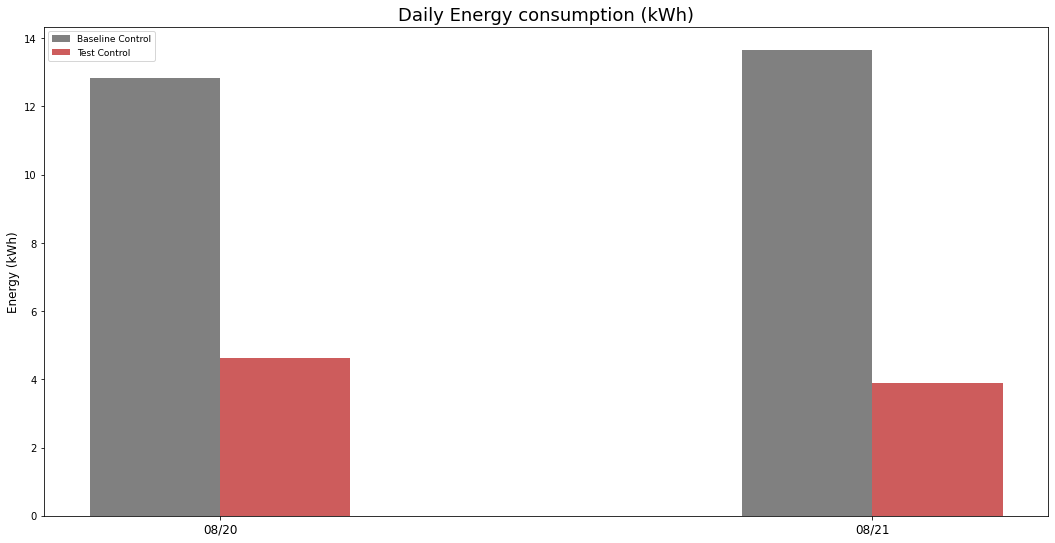

In [13]:
db_plotting.energy_plot(data23, en_1a, en_1b, 'Daily Energy consumption (kWh)', 'Energy (kWh)')

### Shed

In [14]:
data23['G36 Demand Shed'] = data23['cooling_power [W]'] - data22['cooling_power [W]']

shed_1a = []
shed_1b = []

# define dates for the calculation
for day in range(day_range[1], day_range[2]+1):    
    mask_1 = data22['date'] == datetime.date(2021, day_range[0], day)
    #print(day) 
    day_shed_1a = (data22['cooling_power [W]'][mask_1][gta_ts].mean())
    shed_1a.append(day_shed_1a)
    
    day_shed_1b = (data23['cooling_power [W]'][mask_1][gta_ts].mean())
    shed_1b.append(day_shed_1b)


    #day_shed_1b = (data23['G36 Demand Shed'][mask_1][gta_ts].mean())
    #shed_1b.append(day_shed_1b)

In [15]:
data22['cooling_power [W]'][mask_1][gta_ts]

time
2021-08-21 14:15:00    697.580243
2021-08-21 14:30:00    707.845548
2021-08-21 14:45:00    670.559708
2021-08-21 15:00:00    689.532558
2021-08-21 15:15:00    728.999590
2021-08-21 15:30:00    653.052031
2021-08-21 15:45:00    663.426898
2021-08-21 16:00:00    754.199832
2021-08-21 16:15:00    754.064535
2021-08-21 16:30:00    646.633388
2021-08-21 16:45:00    731.767143
2021-08-21 17:00:00    686.372047
2021-08-21 17:15:00    686.856215
2021-08-21 17:30:00    750.478345
2021-08-21 17:45:00    675.056358
2021-08-21 18:00:00    693.817221
Name: cooling_power [W], dtype: float64

In [16]:
print(data23['G36 Demand Shed'][gta_ts])
#print(data23['G36 Demand Shed'])

time
2021-08-20 14:15:00   -649.242542
2021-08-20 14:30:00   -723.427548
2021-08-20 14:45:00   -678.777152
2021-08-20 15:00:00   -726.277787
2021-08-20 15:15:00   -641.000143
2021-08-20 15:30:00   -630.804927
2021-08-20 15:45:00   -725.054782
2021-08-20 16:00:00   -613.094595
2021-08-20 16:15:00   -699.915302
2021-08-20 16:30:00   -599.177671
2021-08-20 16:45:00   -689.673364
2021-08-20 17:00:00   -621.493107
2021-08-20 17:15:00   -689.066514
2021-08-20 17:30:00   -615.990199
2021-08-20 17:45:00   -706.626293
2021-08-20 18:00:00   -594.399710
2021-08-21 14:15:00   -547.540870
2021-08-21 14:30:00   -557.801053
2021-08-21 14:45:00   -520.836011
2021-08-21 15:00:00   -539.665976
2021-08-21 15:15:00   -579.109027
2021-08-21 15:30:00   -503.421298
2021-08-21 15:45:00   -513.874692
2021-08-21 16:00:00   -604.511851
2021-08-21 16:15:00   -604.329153
2021-08-21 16:30:00   -497.136255
2021-08-21 16:45:00   -581.950592
2021-08-21 17:00:00   -536.251983
2021-08-21 17:15:00   -536.865876
2021-08-2

In [17]:
def shed_demand_plot(data, list_1, list_2, title, y_label):
    fig, (ax) = plt.subplots(nrows = 1, ncols = 1, constrained_layout=True, facecolor='w', edgecolor='k',figsize = (18,9))
    fig.subplots_adjust(hspace = .2, wspace=.15)

    inp_day = data['date'].unique() # capture unique dates from the date column
    inp_day = inp_day.tolist() #convert to a list
    #print(inp_day)
    # create labels for each date of the test
    labels = []
    labels1 = []
    for i in range(0,len(inp_day)):
        labels.append(inp_day[i].strftime('%m/%d'))

    #for i in range(0,len(inp_day)-1):
        #labels1.append(inp_day[i].strftime('%m/%d'))

    x = np.arange(len(labels))
    #x = np.arange(len(labels)-1)
    print(labels)
    print(list_2)
    width = .2

    ax.bar(x-width*.5, list_1, width = width, label='Baseline Control', color = 'dodgerblue')
    ax.bar(x+width*.5, list_2, width = width, label='Test Control', color = 'mediumseagreen')

    ax.set_xticks(range(len(labels)))
    #ax.set_xticks(range(len(labels)-1))
    ax.set_xticklabels(labels, fontsize = 12)
    #ax.set_xticklabels(labels[1:len(labels)+1], fontsize = 12)
    ax.set_title(title, fontsize = 18)
    ax.set_ylabel(y_label, fontsize = 12)
    ax.legend(fontsize = 9, loc = 2)

In [18]:
print(shed_1a)

[814.637022061486, 699.3901036740542]


In [19]:
print(shed_1b)

[151.88566986345518, 149.82534222696262]


['08/20', '08/21']
[151.88566986345518, 149.82534222696262]


/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1113/3893193546.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .2, wspace=.15)


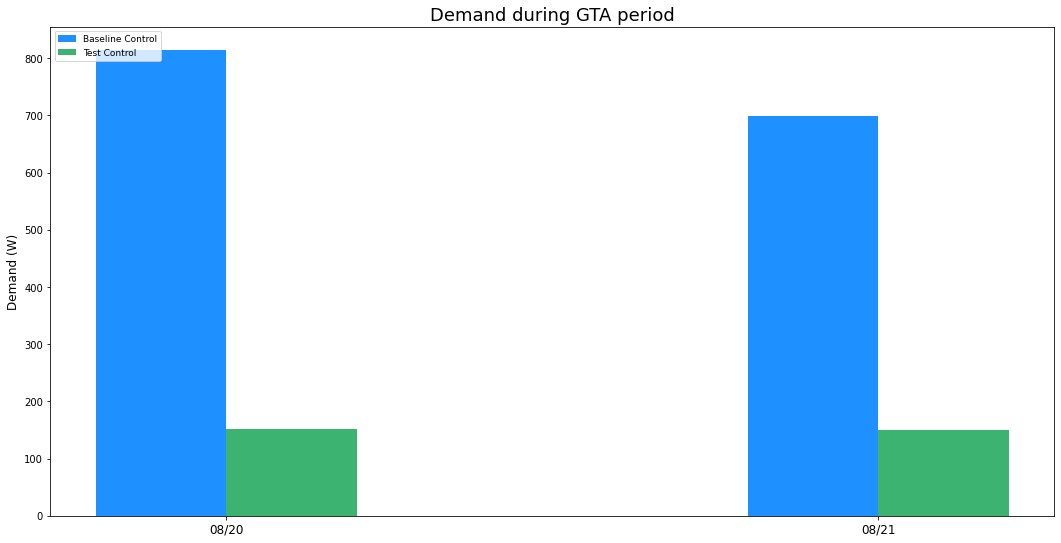

In [20]:

shed_demand_plot(data23, shed_1a, shed_1b, 'Demand during GTA period', 'Demand (W)')

### Thermal comfort

In [21]:
data22 = data22.assign(nor_zat_deg = 'nor_zat_deg') 
#for i in range(len(data20.index)):

def zat_col(df_zat, df_cool_sp):
    df_zat = df_zat.apply(lambda x: (x-32)/1.8)
    df_cool_sp = df_cool_sp.apply(lambda x: (x-32)/1.8)
    
    df_zat_deg = df_zat - df_cool_sp
    df_zat_deg = df_zat_deg.apply(lambda x:0 if x <= 0 else x)
    return (df_zat_deg)

In [22]:
data22['nor_zat_deg'] = zat_col(data22['1A-VAV1-Zn_Temp'], data23['1B-VAV1-OccupiedCoolingSetpt'])
data22['cor_zat_deg'] = zat_col(data22['1A-VAV2-Zn_Temp'], data23['1B-VAV2-OccupiedCoolingSetpt'])
data22['sou_zat_deg'] = zat_col(data22['1A-VAV3-Zn_Temp'], data23['1B-VAV3-OccupiedCoolingSetpt'])

data23['nor_zat_deg'] = zat_col(data23['1B-VAV1-Zn_Temp'], data23['1B-VAV1-OccupiedCoolingSetpt'])
data23['cor_zat_deg'] = zat_col(data23['1B-VAV2-Zn_Temp'], data23['1B-VAV2-OccupiedCoolingSetpt'])
data23['sou_zat_deg'] = zat_col(data23['1B-VAV3-Zn_Temp'], data23['1B-VAV3-OccupiedCoolingSetpt'])

In [23]:
def calc_stats(df, df_temp):
   
    overshoot = []
    mean = []
    median = []
    std = []
    oc_st = datetime.time(7,0,0)
    oc_en = datetime.time(19,0,0)

    oc_time = ((df['time'] >= oc_st) & (df['time'] <= oc_en))
        
    for day in range(day_range[1],day_range[2]+1):    
        mask_1 = data22['date'] == datetime.date(2021, day_range[0], day)
        daily_mean = df_temp[mask_1][oc_time].mean()
        daily_median = df_temp[mask_1][oc_time].median()
        #print('Variance', df[df[i] > target[i]].var())
        daily_std = df_temp[mask_1][oc_time].std()
        
        mean.append(daily_mean)
        median.append(daily_median)
        std.append(daily_std)
        
        daily_shoot = sum(df_temp[mask_1][oc_time]*.25)
        counter = sum(df_temp[mask_1][oc_time]>0)
        overshoot.append(daily_shoot)
        

    return(overshoot, mean, median, std)

In [24]:
data22_nor_zat_deg, data22_nor_mean, data22_nor_median, data22_nor_std = calc_stats(data22, data22['nor_zat_deg'])
data22_cor_zat_deg, data22_cor_mean, data22_cor_median, data22_cor_std = calc_stats(data22, data22['cor_zat_deg'])
data22_sou_zat_deg, data22_sou_mean, data22_sou_median, data22_sou_std = calc_stats(data22, data22['sou_zat_deg'])

data23_nor_zat_deg, data23_nor_mean, data23_nor_median, data23_nor_std = calc_stats(data23, data23['nor_zat_deg'])
data23_cor_zat_deg, data23_cor_mean, data23_cor_median, data23_cor_std = calc_stats(data23, data23['cor_zat_deg'])
data23_sou_zat_deg, data23_sou_mean, data23_sou_median, data23_sou_std = calc_stats(data23, data23['sou_zat_deg'])

In [25]:
print(data22_nor_zat_deg, data22_nor_mean, data23_nor_median, data23_nor_std)

[nan, 0.0] [0.0, 0.0] [0.0, 0.0] [0.0, 0.0]


In [26]:
scenario_dict = {}
scenario_dict[1] = calc_stats(data22, data22['nor_zat_deg'])
scenario_dict[2] = calc_stats(data22, data22['cor_zat_deg'])
scenario_dict[3] = calc_stats(data22, data22['sou_zat_deg'])

scenario_dict[4] = calc_stats(data23, data23['nor_zat_deg'])
scenario_dict[5] = calc_stats(data23, data23['cor_zat_deg'])
scenario_dict[6] = calc_stats(data23, data23['sou_zat_deg'])

In [27]:
scenario_dict = {'data22': {"nor": calc_stats(data22, data22['nor_zat_deg']),
                            "cor": calc_stats(data22, data22['cor_zat_deg']), 
                            "sou": calc_stats(data22, data22['sou_zat_deg'])}, 
                 
                 'data23': {"nor": calc_stats(data23, data23['nor_zat_deg']),
                            "cor": calc_stats(data23, data23['cor_zat_deg']), 
                            "sou": calc_stats(data23, data23['sou_zat_deg'])}}

In [28]:
print(scenario_dict['data23']['sou'])
print(scenario_dict['data23']['sou'][0][1:5])

([0.28472222222222054, 0.0], [0.023242630385487392, 0.0], [0.0, 0.0], [0.07358641679944303, 0.0])
[0.0]


In [29]:
print(sum(data22_nor_zat_deg), sum(data23_nor_zat_deg))
print(sum(data22_cor_zat_deg), sum(data23_cor_zat_deg))
print(sum(data22_sou_zat_deg), sum(data23_sou_zat_deg))

nan 0.0
nan 0.540277777777785
nan 0.28472222222222054


In [30]:
print(data22_nor_zat_deg,data22_cor_zat_deg,data22_sou_zat_deg)

[nan, 0.0] [nan, 0.0] [nan, 0.0]


In [31]:
print(data23_nor_zat_deg,data23_cor_zat_deg,data23_sou_zat_deg)

[0.0, 0.0] [0.26388888888889284, 0.2763888888888921] [0.28472222222222054, 0.0]


In [32]:
import matplotlib.dates as mdates

def thermal_comfort_plot(data_1, inp_1, inp_2, inp_3, inp_4, inp_5, inp_6, scenario_dict, metric, ylabel, title_dict):
    
    # data_1 is the full RAW data, have 6 inputs, 
    
    fig, (ax, ax1, ax2) = plt.subplots(nrows = 3, ncols = 1, constrained_layout=True, facecolor='w', edgecolor='k',
                                       figsize = (18,9))
    
    
    
    fig.subplots_adjust(hspace = .2, wspace=.15)
    # so the row is 3 and columns is 1 

    inp_day = data_1['date'].unique() # capture unique dates from the date column
    inp_day = inp_day.tolist() #convert to a list for unique days
    
    
    import datetime
    for i in range(len(inp_day)):
        inp_day[i]=datetime.datetime.combine(inp_day[i], datetime.datetime.min.time())

    # create labels for each date of the test
    labels = []
    labels1 = []
    for i in range(0,len(inp_day)):
        labels.append(inp_day[i].strftime('%m/%d'))

    print(labels) # print out the variable "labels" with unique days

    x = np.array(inp_day)
    
    print(x)
    print(inp_1[metric][0:len(labels)+1])# print the 0:overshoot, 1:mean data for all days from the first input
    
    shift1 = datetime.timedelta(hours = 1.5)
    shift2 = datetime.timedelta(hours = 4.5)
    width = datetime.timedelta(hours = 3)
    
    #ax.xaxis_date()
    ax.get_xaxis().set_visible(False)
    ax02 = ax.twinx()
    ax02.plot(data_1['1B-OAT-1'])
    #ax.set_xticks(range(len(labels)))
    ax.bar(x+shift1, inp_1[metric][0:len(labels)+1], width = width, label='Baseline Control', color = 'darkgrey')
    ax.bar(x+shift2, inp_2[metric][0:len(labels)+1], width = width, label='Test Control', color = 'dimgrey')
    
    # plot 1st and 2nd input of the 0:overshoot, 1:mean data with the width data defined above
    
    ax12 = ax1.twinx()
    ax12.plot(data_1['1B-OAT-1'])
    ax1.bar(x+shift1, inp_3[metric][0:len(labels)+1], width = width, label='Baseline Control', color = 'mediumseagreen')
    ax1.bar(x+shift2, inp_4[metric][0:len(labels)+1], width = width, label='Test Control', color = 'olivedrab')
    
    
    # plot 3rd and 4th input of the 0:overshoot, 1:mean data 
    
    
    ax22 = ax2.twinx()
    ax22.plot(data_1['1B-OAT-1'])
    ax2.bar(x+shift1, inp_5[metric][0:len(labels)+1], width = width, label='Baseline Control', color = 'indianred')
    ax2.bar(x+shift2, inp_6[metric][0:len(labels)+1], width = width, label='Test Control', color = 'crimson')
    
    
    # plot 5th and 6th input of the 0:overshoot, 1:mean data 
    fig.suptitle(title_dict, fontsize = 18)  # title for the full plot
    
    ax.set_title('North zone', fontsize = 16)
    ax.set_ylabel(ylabel, fontsize = 9)
    ax.legend(fontsize = 9, loc = 2)
    if metric == 0:
        ax.set_ylim(0,2.5)
    else:
        ax.set_ylim(0,0.5)

    
    ax1.legend(fontsize = 9, loc = 2)
    ax1.set_title('Core zone', fontsize = 16)
    ax1.set_ylabel(ylabel, fontsize = 9)
    if metric == 0:
        ax1.set_ylim(0,2.5)
    else:
        ax1.set_ylim(0,0.5)
        
    ax1.get_xaxis().set_visible(False)

    ax2.legend(fontsize = 9, loc = 2)
    ax2.set_title('South zone', fontsize = 16)
    ax2.set_ylabel(ylabel, fontsize = 9)
    #ax2.set_xticks(range(len(labels)))
    if metric == 0:
        ax2.set_ylim(0,2.5)
    else:
        ax2.set_ylim(0,0.5)
        
        # above sets the y limit and legend font size...
        
        
    
    #ax2.xaxis_date()
    ax2.set_xticklabels(labels, fontsize = 12)

    ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 
    for label in ax2.get_xticklabels():
        label.set_rotation(40)     # Format the x label at the last graph!

/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1113/2005965882.py:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .2, wspace=.15)
/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1113/2005965882.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels, fontsize = 12)


['08/20', '08/21']
[datetime.datetime(2021, 8, 20, 0, 0) datetime.datetime(2021, 8, 21, 0, 0)]
[0.0, 0.0]


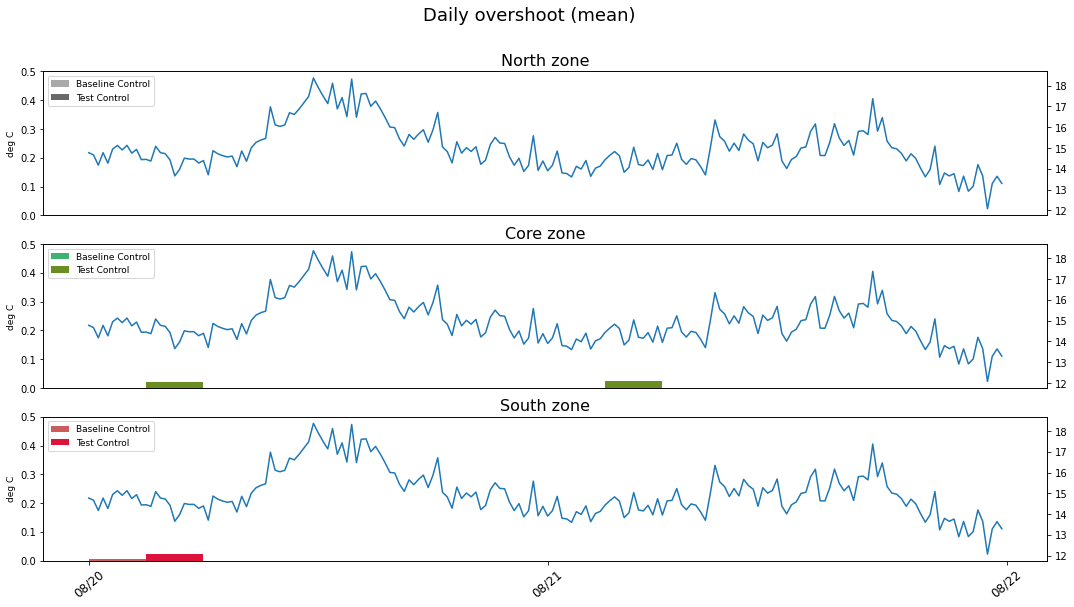

In [35]:
# key for metrics to be plotted in the scenario dictionary; {1:'overshoot', 2:'mean', 3:'median', 4:'std_dev'}
title_dict = {1: 'Daily overshoot (deg C hour)', 2:'Daily overshoot (mean)', 3:'Daily overshoot (median)' , 4:'Daily overshoot (standard deviation)'}
ylabel = {1: 'deg C - hour', 2: 'deg C', 3: 'deg C', 4: 'deg C'}
thermal_comfort_plot(data22, scenario_dict['data22']['nor'], scenario_dict['data23']['nor'], 
                                 scenario_dict['data22']['cor'], scenario_dict['data23']['cor'], 
                                 scenario_dict['data22']['sou'], scenario_dict['data23']['sou'],
                                 scenario_dict, 1, ylabel[2], title_dict[2])

# Zone Air Temperature

/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1113/2660902818.py:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .4, wspace=.15)


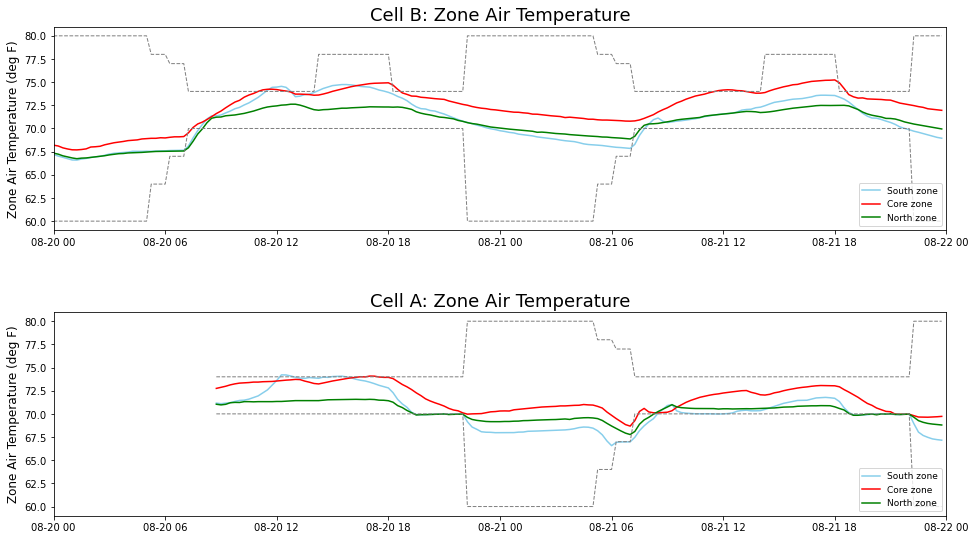

In [34]:
fig, (ax1, ax) = plt.subplots(nrows = 2, ncols = 1, constrained_layout=True, facecolor='w', edgecolor='k',figsize = (16,9))
fig.subplots_adjust(hspace = .4, wspace=.15)

ax1.plot(data23['1B-VAV3-Zn_Temp'], label = 'South zone', color = 'skyblue')
ax1.plot(data23['1B-VAV2-Zn_Temp'], label = 'Core zone', color = 'red')
ax1.plot(data23['1B-VAV1-Zn_Temp'], label = 'North zone', color = 'green')
ax1.plot(data23['1B-VAV3-OccupiedCoolingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')
ax1.plot(data23['1B-VAV3-OccupiedHeatingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')

ax.plot(data22['1A-VAV3-Zn_Temp'], label = 'South zone', color = 'skyblue')
ax.plot(data22['1A-VAV2-Zn_Temp'], label = 'Core zone', color = 'red')
ax.plot(data22['1A-VAV1-Zn_Temp'], label = 'North zone', color = 'green')
ax.plot(data22['1A-VAV3-OccupiedCoolingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')
ax.plot(data22['1A-VAV3-OccupiedHeatingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')

ax1.set_ylabel('Zone Air Temperature (deg F)', fontsize = 12)
ax.set_ylabel('Zone Air Temperature (deg F)', fontsize = 12)

ax1.set_title('Cell B: Zone Air Temperature', fontsize = 18)
ax.set_title('Cell A: Zone Air Temperature', fontsize = 18)

ax1.set_xlim([datetime.date(2021, day_range[0], day_range[1]),datetime.date(2021, day_range[0], day_range[2]+1)]) 
ax.set_xlim([datetime.date(2021, day_range[0], day_range[1]),datetime.date(2021, day_range[0], day_range[2]+1)])


#ax1.set_xlim(["2021-08-20 08:50:00"],["2021-08-22 00:00:00"]) 
#ax.set_xlim(["2021-08-20 08:50:00"],["2021-08-22 00:00:00"])

ax.legend(fontsize = 9, loc = 4)
ax1.legend(fontsize = 9, loc = 4)